## Study B analyses

In [3]:
import os, sys
sys.path.append(os.path.dirname(os.path.realpath("./"))) # Add parent to path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
from scipy.stats import linregress
from plots import bars, plot_linreg

In [6]:
plt.style.use("jg.mplstyle")

In [3]:
df_trials = pd.read_pickle('./frames/df_trials.pickle')
df_subjs = pd.read_pickle('./frames/df_subjs.pickle')
df_anovas = pd.read_pickle('./frames/df_anovas.pickle')

In [4]:
# Do participants detect spatial structure in Study B?

maps_ordered = list(df_trials.groupby('map').gem_ev.mean().sort_values().index)

df_trials['gem_ev_rank'] = df_trials['map'].map(lambda map_val : maps_ordered.index(map_val)+1)

df_spatial = df_trials[df_trials.map_kind == "spatial"]

In [5]:
df_trials.groupby('map')[['gem_ev', 'gem_ev_rank', 'score']].mean()

,gem_ev,gem_ev_rank,score
map,,,
mLsNOgLoA_1,74.0625,42.0,72.465517
mLsNOgLoA_2,78.4375,57.0,76.724138
mLsNOgLoA_3,77.8125,56.0,79.586207
mLsNOgLoA_4,72.1875,38.0,72.879310
mLsNOgLoA_5,86.8750,69.0,83.000000
...,...,...,...
mSsOFgSoI_1,76.8750,50.0,67.017241
mSsOFgSoI_2,80.0000,63.0,74.396552
mSsOFgSoI_3,61.8750,24.0,66.896552


151.0


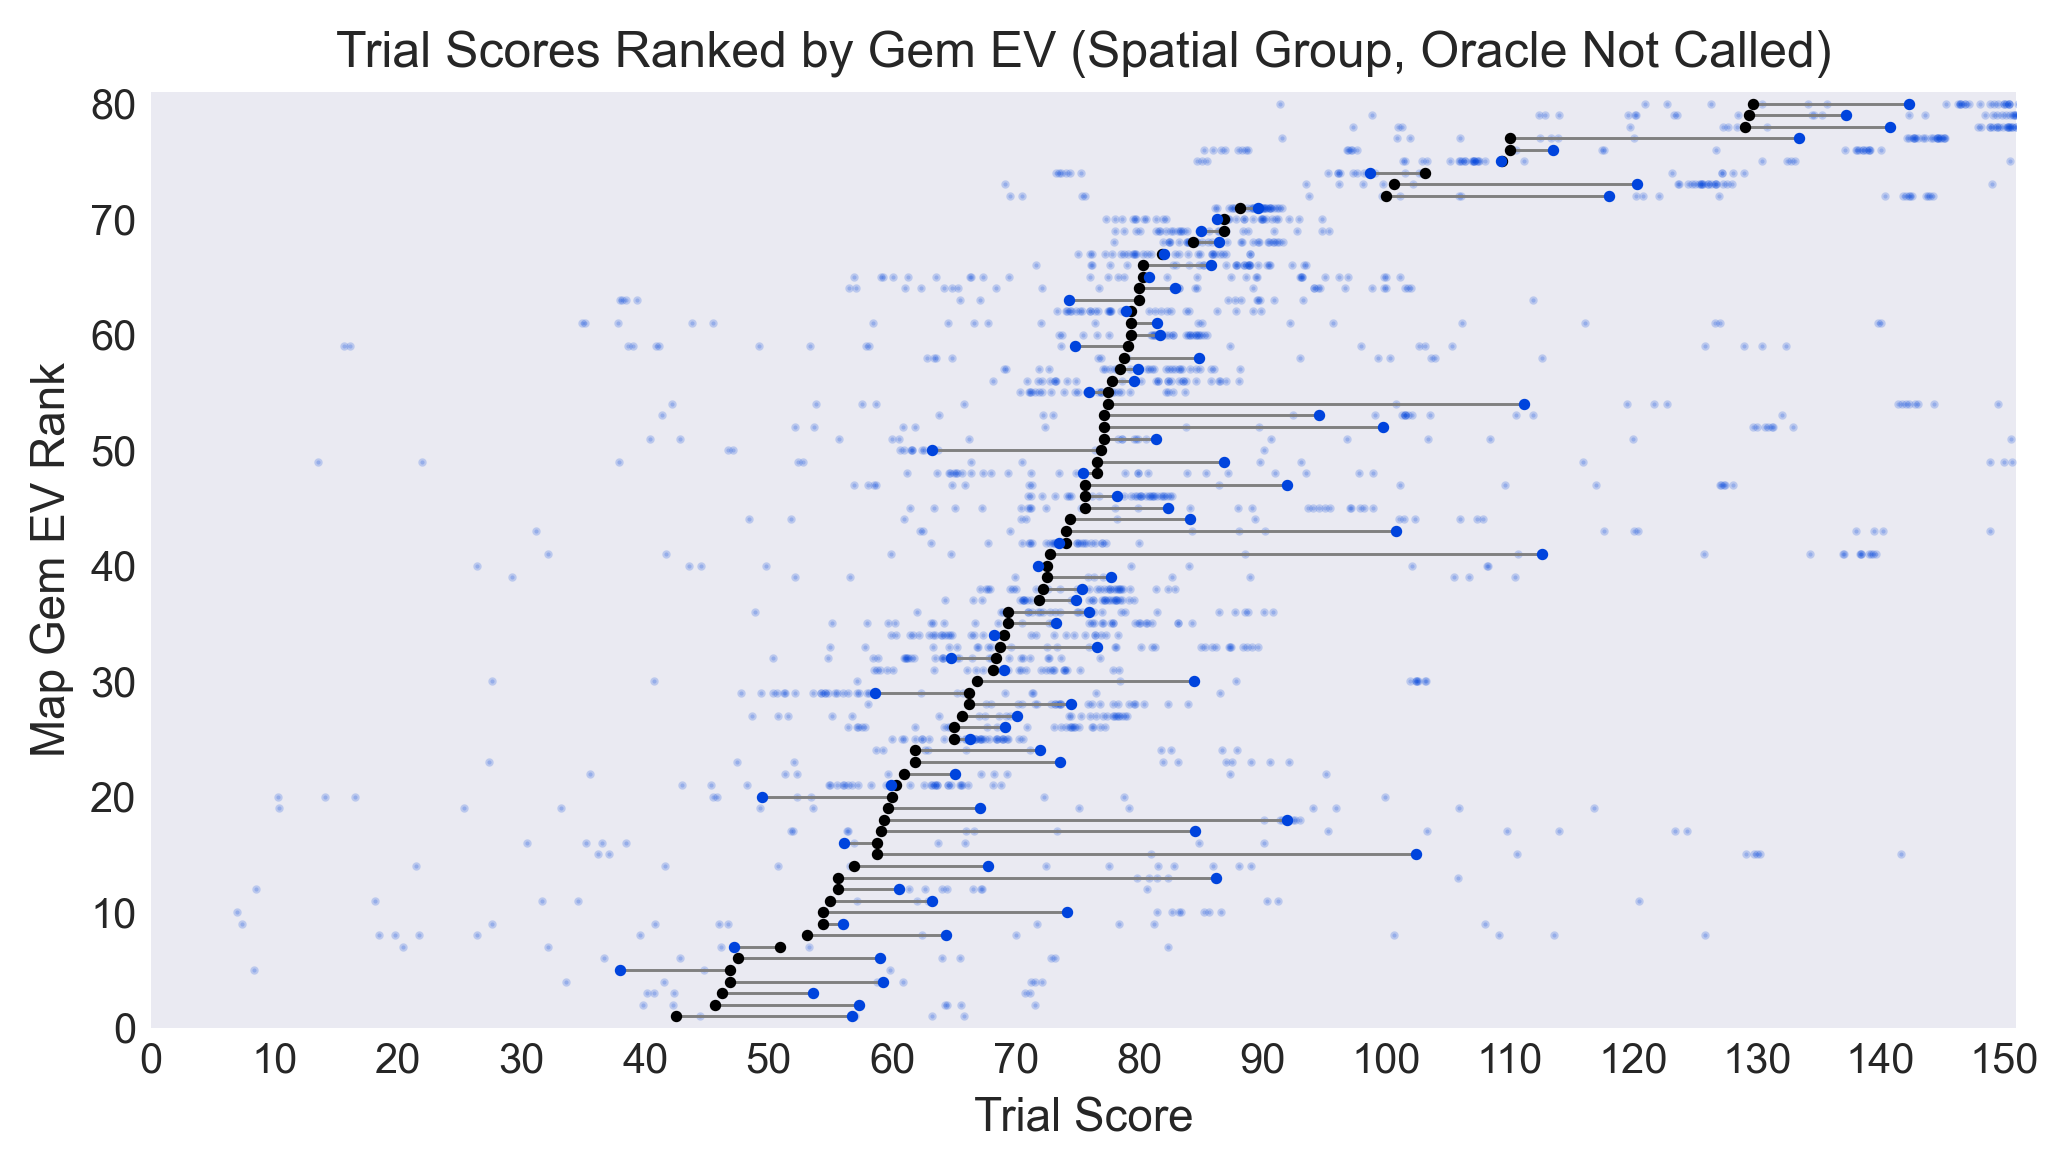

151.0


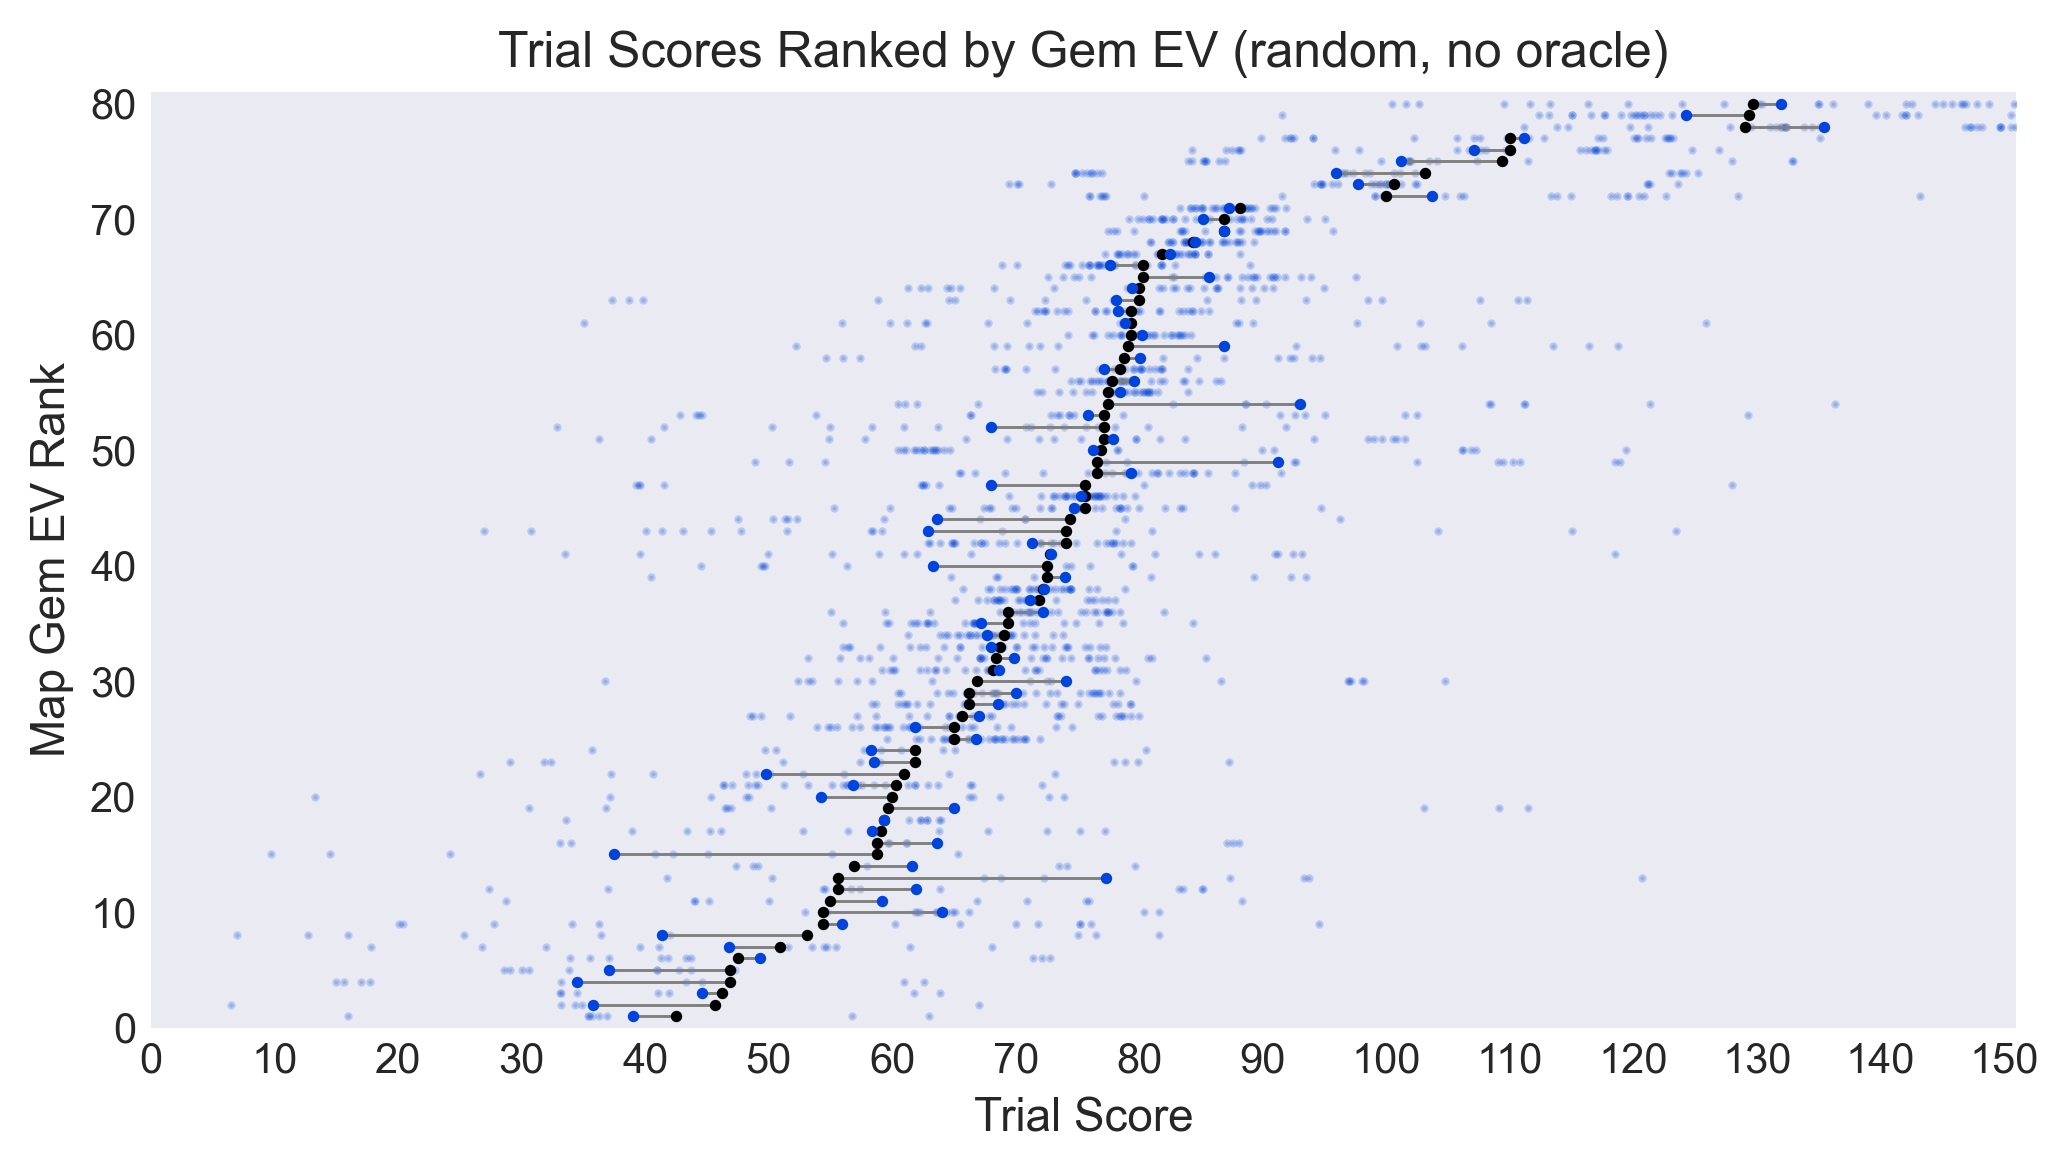

In [14]:
def gem_ev_strip(df, title=None, jitter=1., color='#0044dd', fn=None):
    fig, ax = plt.subplots(1, 1, dpi=300)
    ax.scatter(df['score'] + jitter*np.random.normal(size=len(df)), df['gem_ev_rank'], color=color, s=1, alpha=0.2)
    n_maps = len(maps_ordered)
    yticks = np.arange(0, 81, 10)
    xmax = df.score.max() + 1
    print(xmax)
    ax.set_ylabel("Map Gem EV Rank")
    ax.set_xlabel("Trial Score")
    ax.set_xlim((0, xmax))
    ax.set_ylim((0, 81))

    trial_gem_evs = df.groupby('map')[['gem_ev', 'gem_ev_rank', 'score']].mean()

    # Connecting lines
    for key, row in trial_gem_evs.iterrows():
        ax.plot([row.gem_ev, row.score], [row.gem_ev_rank, row.gem_ev_rank], color='gray', lw=0.7)
    
    # Add trial gem EV
    ax.scatter(trial_gem_evs['gem_ev'], trial_gem_evs['gem_ev_rank'], s=3, color='black', zorder=10)

    # Add trial mean score
    ax.scatter(trial_gem_evs['score'], trial_gem_evs['gem_ev_rank'], s=3, color=color, zorder=10)
    ax.set_title(title)

    ax.set_yticks(yticks)
    ax.set_yticklabels([str(x) for x in yticks])
    xticks = np.arange(0, xmax, 10)
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(int(x)) for x in xticks])
    plt.tight_layout()
    if fn:
        plt.savefig("./figures/%s.png" % fn, bbox_inches=0.0)
    plt.show()

gem_ev_strip(df_trials[(df_trials.map_kind == "spatial") & (df_trials.oracle_requested == 0)], title="Trial Scores Ranked by Gem EV (Spatial Group, Oracle Not Called)", fn="score_vs_gem_ev_spatial")
gem_ev_strip(df_trials[(df_trials.map_kind == "random") & (df_trials.oracle_requested == 0)], title="Trial Scores Ranked by Gem EV (random, no oracle)")

In [7]:
ius_median = np.median(df_subjs.ius_score)
for key, row in df_subjs.iterrows():
    ius_type = 'high' if row.ius_score > ius_median else 'low'
    df_subjs.loc[key, 'ius_type'] = ius_type

In [8]:
for key, row in df_spatial.iterrows():
    df_spatial.loc[key, 'ius_type'] = df_subjs[df_subjs.user_id == row.user_id].iloc[0].ius_type

/var/folders/1h/7q13n39d72ng7v6xgcj3rnxm0000gn/T/ipykernel_6883/1434682248.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spatial.loc[key, 'ius_type'] = df_subjs[df_subjs.user_id == row.user_id].iloc[0].ius_type


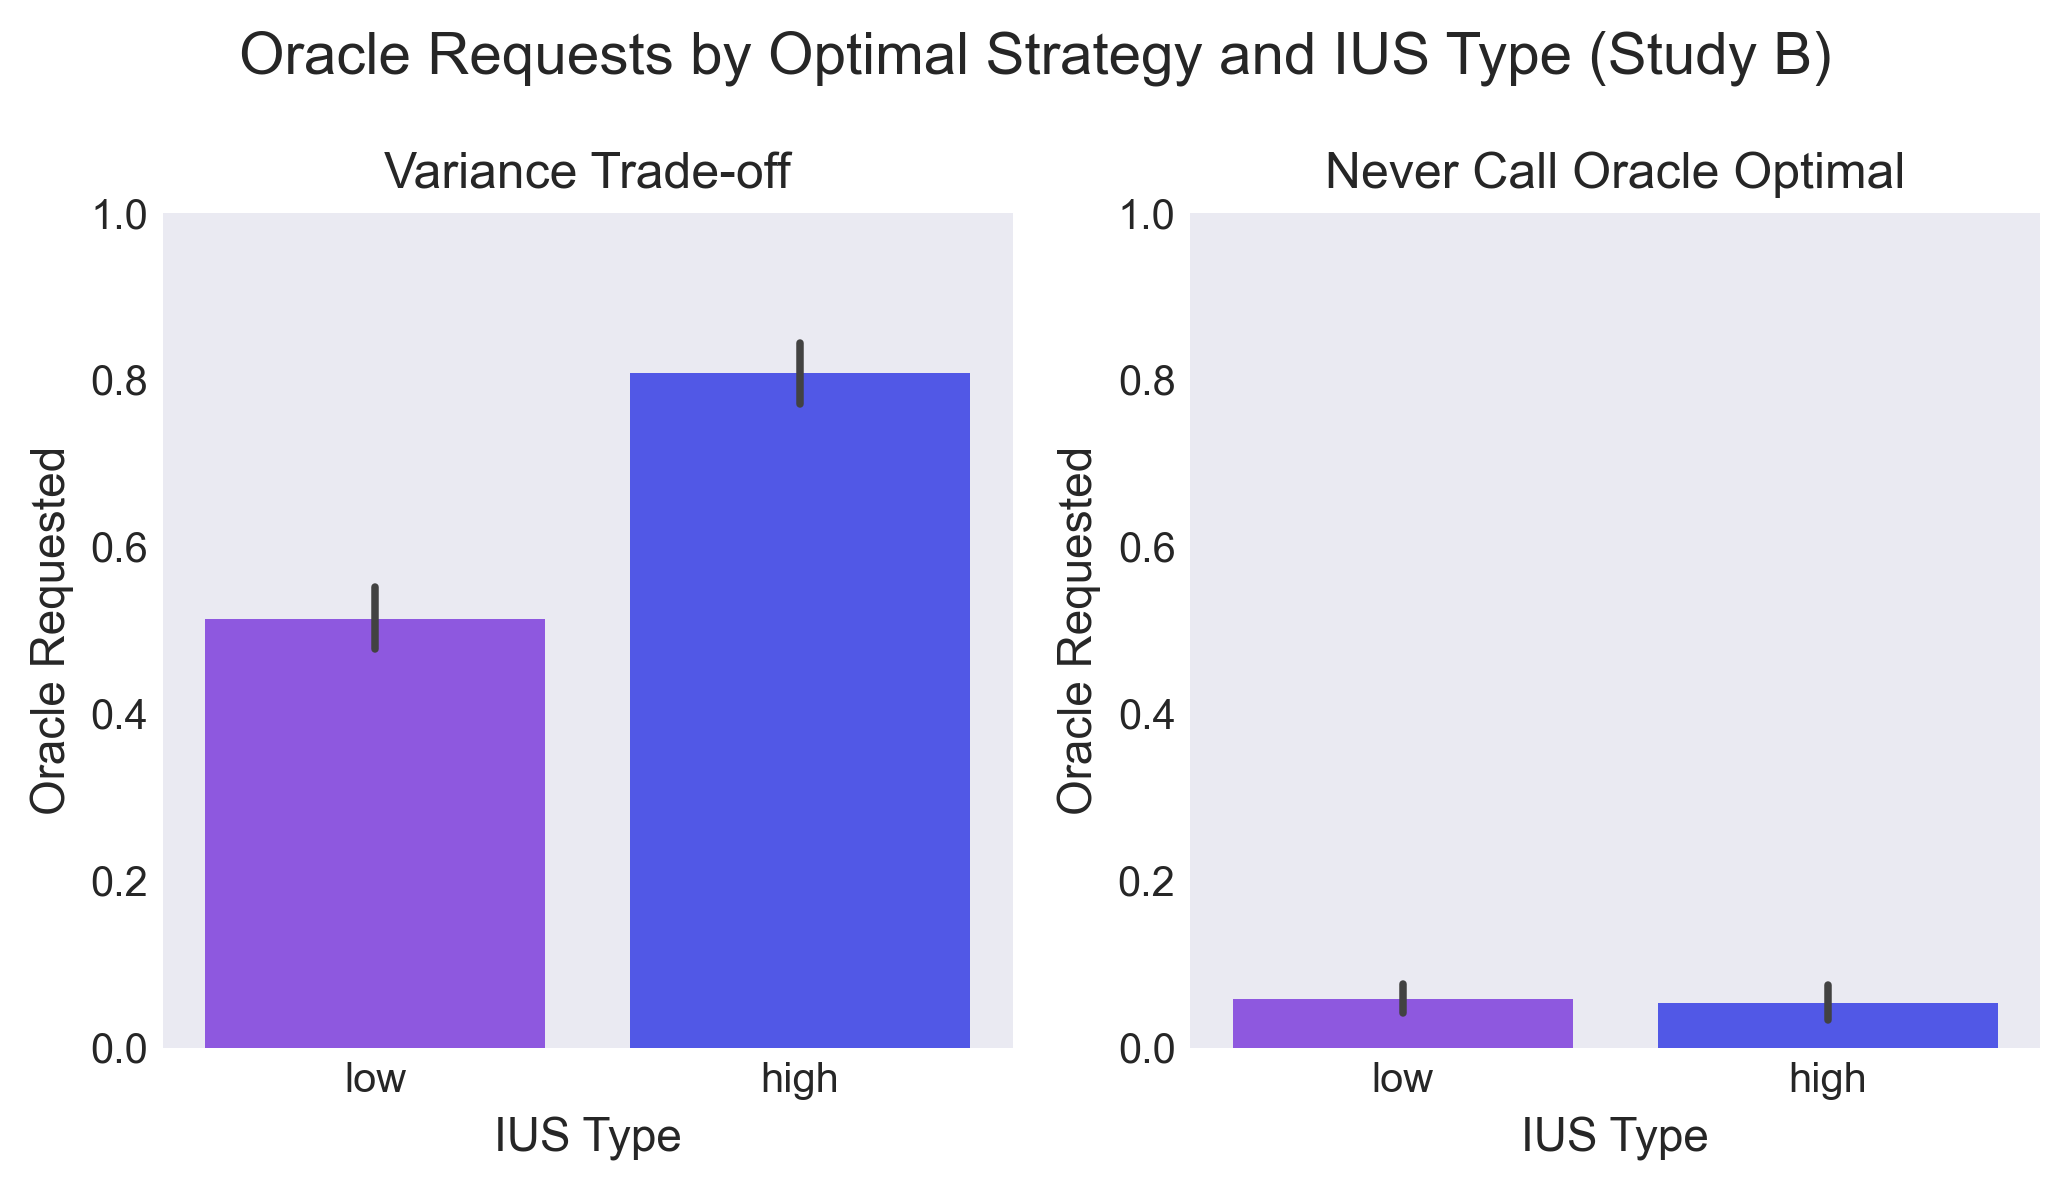

In [9]:
bars(x='ius_type', y='oracle_requested', hue=None, df=df_spatial, 
     ylabel="Oracle Requested", xlabel="IUS Type", 
     figure_attr="cond_best_strat", figure_vals=["OF", "NO"],
     figure_labels=["Variance Trade-off", "Never Call Oracle Optimal"],
     palette=["#8a42f5", "#3842ff"], suptitle="Oracle Requests by Optimal Strategy and IUS Type (Study B)", save="oracle_ius_bar")            

In [10]:
df_subjs_spatial = df_subjs[df_subjs.map_kind == "spatial"]

In [11]:
df_subjs_spatial.columns

Index(['user_id', 'match_id', 'map_kind', 'ius_score', 'total_score',
       'total_score_s', 'total_score_l', 'total_score_of', 'total_score_no',
       'total_oracle_requests', 'total_oracle_requests_s',
       'total_oracle_requests_l', 'total_oracle_requests_of',
       'total_oracle_requests_no', 'total_correct_strat', 'ius_type'],
      dtype='object')

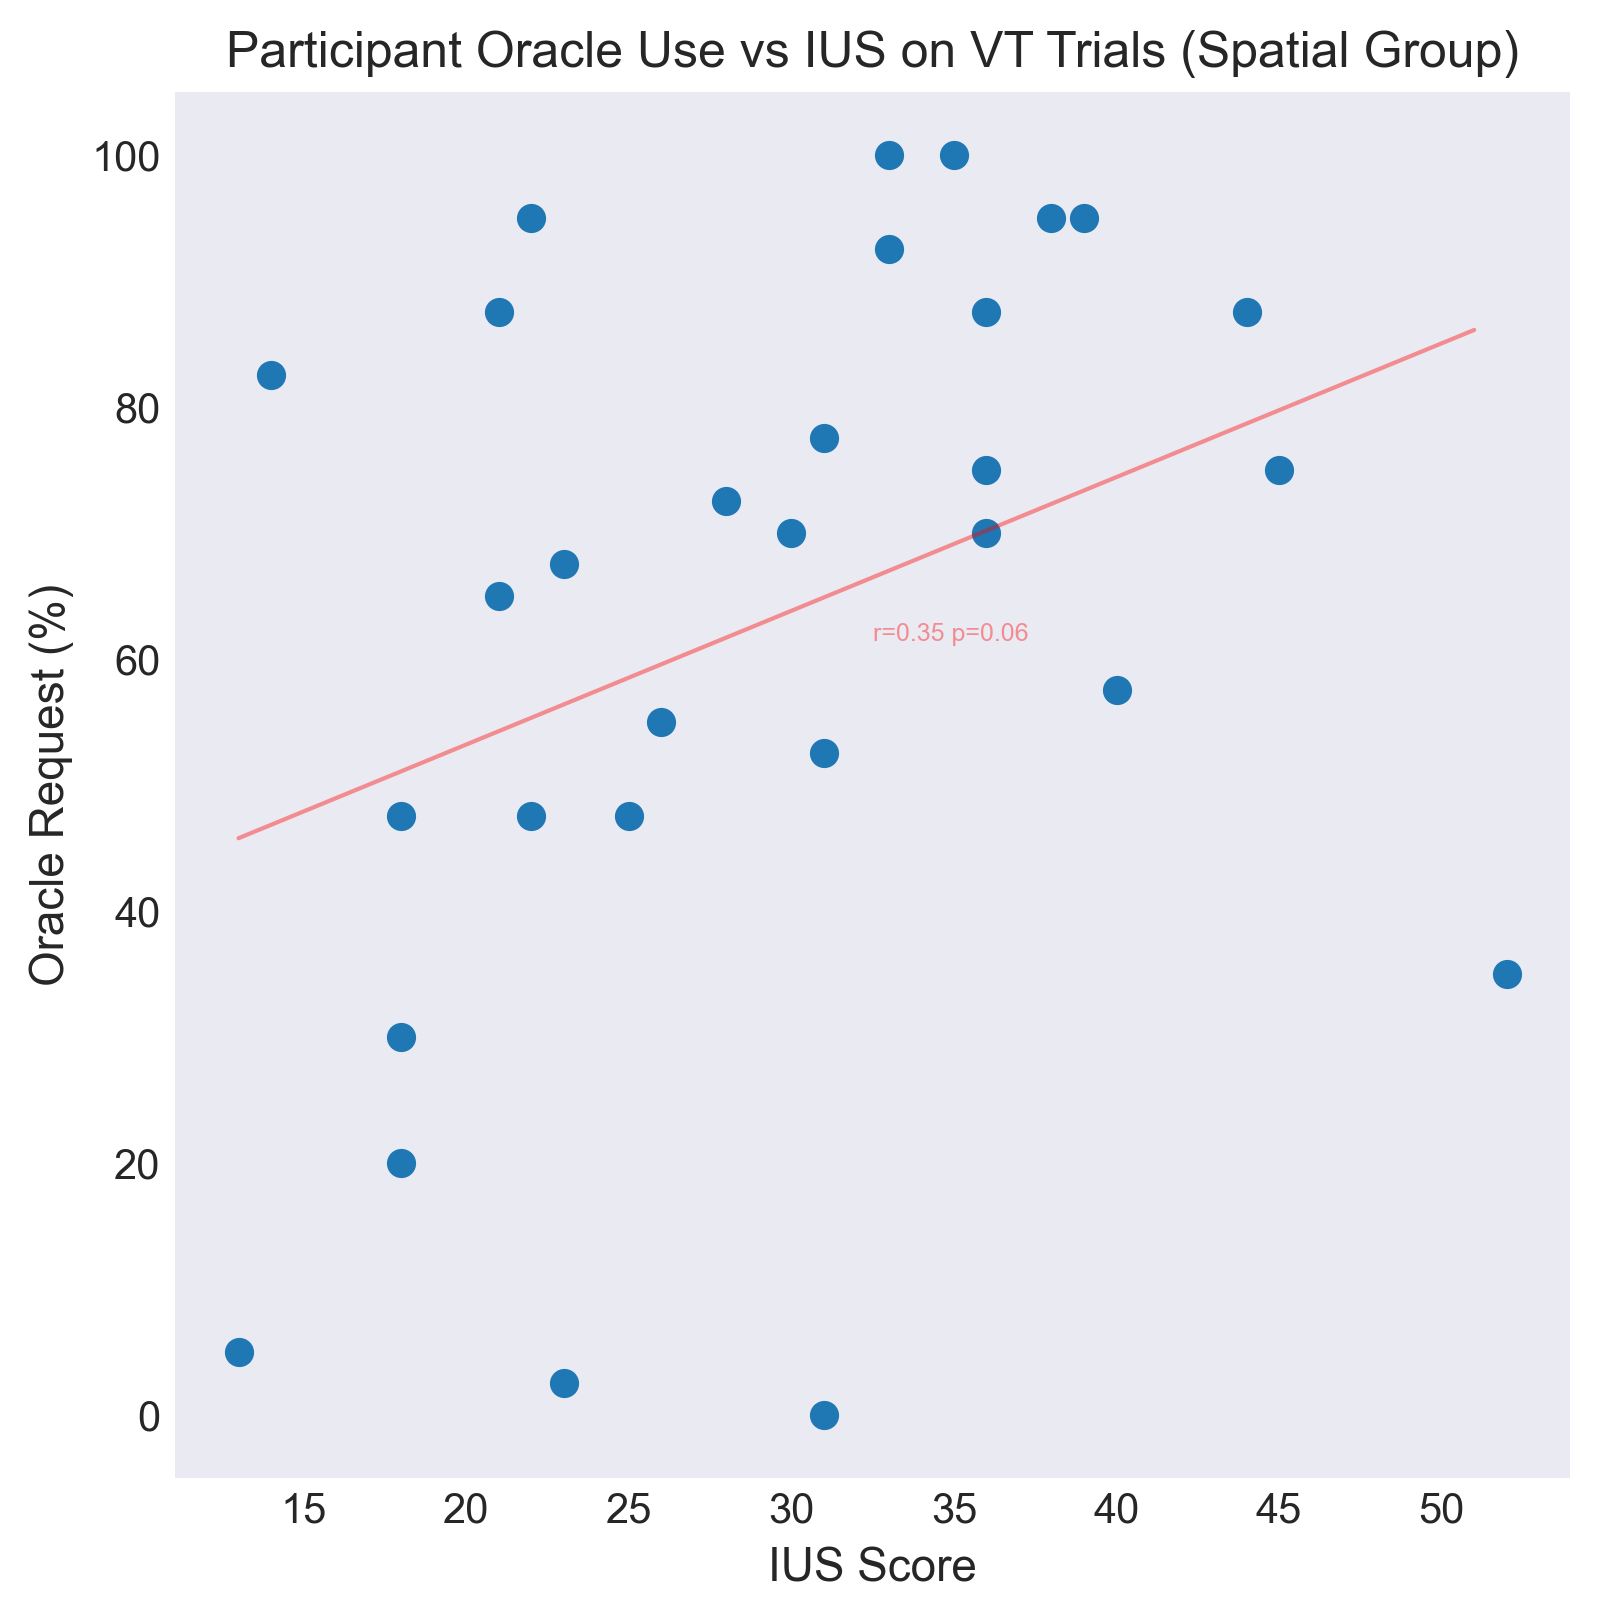

In [12]:
X, Y = [], []
for key, subj in df_subjs_spatial.iterrows():
    X.append(subj.ius_score)
    Y.append(100. * df_spatial[(df_spatial.cond_best_strat == "OF") & (df_spatial.match_id == subj.match_id)].oracle_requested.mean())
X = np.array(X)
Y = np.array(Y)

fig, ax = plt.subplots(dpi=300, figsize=(6, 6))
plot_linreg(X, Y, ax)
ax.scatter(X, Y)
ax.set_title("Participant Oracle Use vs IUS on VT Trials (Spatial Group)")
ax.set_xlabel("IUS Score")
ax.set_ylabel("Oracle Request (%)")
plt.savefig("./figures/oracle_use_vs_ius_vt.png", bbox_inches=0)
plt.show()

In [ ]:
sns.scatterplot(data=df_spatial[df_spatial.cond_best_strat == "OF"], x='ius_score', y='oracle_requested')